## Lab 6-3: Blowing snow - snow redistribution on the site scale

Created by Eli Schwat - February 2025

Credit to Ethan Gutmann and Marianne Cowherd, for sending me easy-to-use subset of the massive lidar archive.

---

In [1]:
import xarray as xr
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

The files required for this lab are large, so they are not downloadable directly from the website. 

Download them from the following link: 

https://drive.google.com/drive/folders/1I8DEuj2ddT1TKXhBvVBL1lHJvbd2D_S0?usp=sharing

## Redistribution of the snowpack by blowing snow - infilling of depressions

Below, we open a lidar dataset. The lidar was mounted at 10 meters above the ground, pointing at an angle towards the ground. The dataset contains values of "distance from the lidar". 

In [2]:
ds = xr.open_dataset('~/Downloads/dec22_l1_clip.nc')

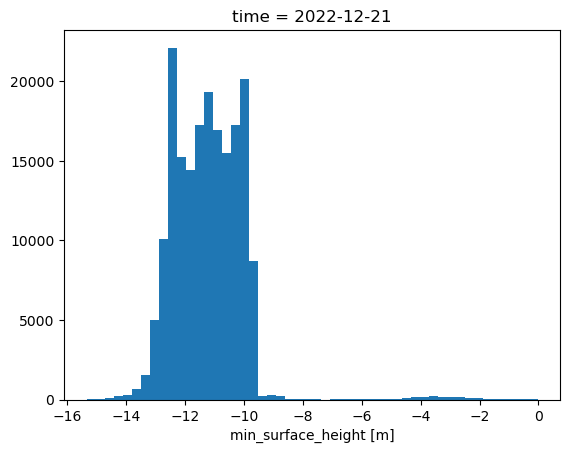

In [3]:
ds.sel(time='20221221 0000')['surface'].plot.hist(bins=50)
plt.show()

Looking at a histogram of values, we can see that the distribution of values ranges from -14 to -9, which makes sense for the lidar mounted at 10m, pointed at an angle towards the ground.

While values of "distance from the ground" are hard to interpret, if we subtract two snapshots from eachother, we will calculate the change in snow-surface elevation.

Below, we do just this, calculating the difference in snow surface elevation between Dec 21 12am and Dec 23 12am, which according to Lundquist et al., 2024 (from earlier in the class), is the timing of a major blowing snow event that filled in a depression at the field site.

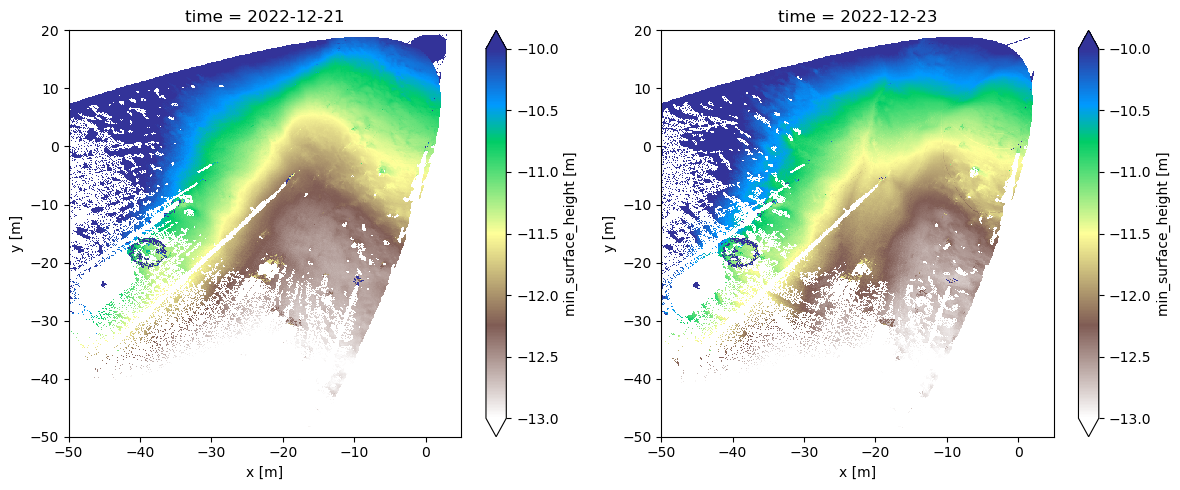

In [4]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ds.sel(time='20221221 0000')['surface'].plot(vmin=-13, vmax=-10, ax=axes[0], cmap='terrain_r')
ds.sel(time='20221223 0000')['surface'].plot(vmin=-13, vmax=-10, ax=axes[1], cmap='terrain_r')
plt.tight_layout()

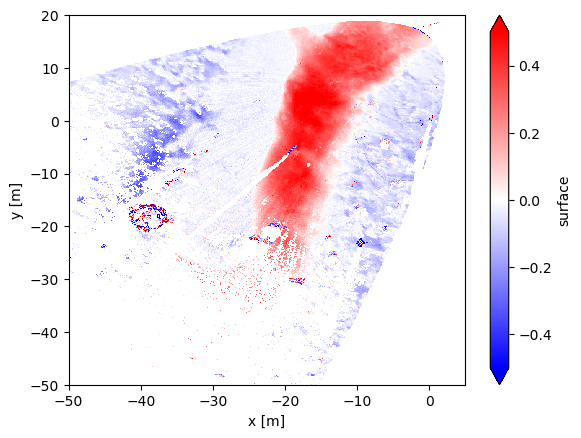

In [5]:
(ds.sel(time='20221223 0000')['surface'] - ds.sel(time='20221221 0000')['surface']).plot(
    vmin=-0.5, vmax=0.5, cmap='bwr'
)

We can see the depression infilling over 48 hours above. This is also shown in Lundquist et al. (2024).

## Blowing snow - snow dunes

Below, we open some lidar data from March 23, a day on which we observed the formation and migration of snow dunes across the Kettle Ponds site.

In [6]:
ds = xr.open_dataset('~/Downloads/mar23_l1_clip.nc')

If we look at a single snapshot, we see that the snow surface at Kettle Ponds in March was sloping.

In [7]:
single_snapshot = ds.sel(time = ds.time[12])

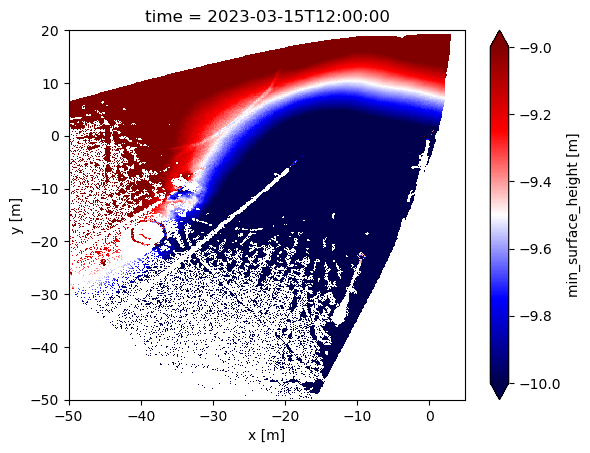

In [8]:
single_snapshot['surface'].plot(vmin=-10, vmax=-9, cmap='seismic')

It's hard to see what's going on with the snow surface here. 

What we want to look at is deviations around that mean sloping surface.

We can calculate this. First, we calculate the mean across time for each pixel. Then we subtract that pixel-wise mean from a timestamp, which will reveal the snow surface topgraphy.

In [9]:
# Calculate pixel-wise mean from the entire dataset
pixel_wise_mean = np.nanmean(ds['surface'], axis=(0))

# Select a specific time stamp from the dataset
specific_timestamp = ds['surface'].sel(time = ds.time[19])

# Subtract the pixel-wise mean from the specific timestamp
# We call this the "normalized" dataset
normed = specific_timestamp - pixel_wise_mean

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_55907/1597827072.py:2: RuntimeWarning: Mean of empty slice
  pixel_wise_mean = np.nanmean(ds['surface'], axis=(0))


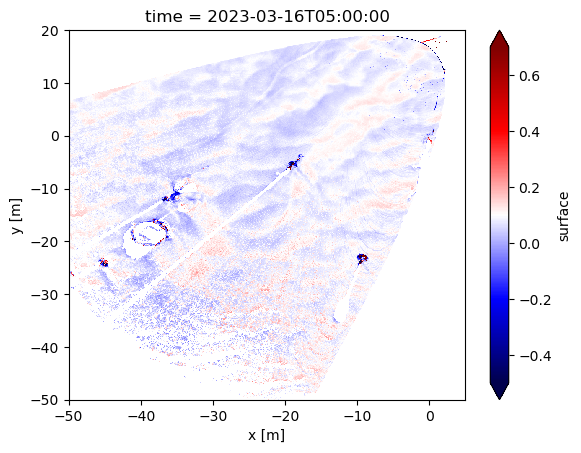

In [10]:
normed.plot(vmin=-0.5, vmax=0.7, cmap='seismic')

Woah! We can see snow dunes!

How can we tell if these dunes are migrating? Let's plot multiple snapshots, sequential in time, next to eachother.

In [11]:
specific_timestamp_1 = ds['surface'].sel(time = ds.time[19])
normed_1 = specific_timestamp_1 - pixel_wise_mean

specific_timestamp_2 = ds['surface'].sel(time = ds.time[20])
normed_2 = specific_timestamp_2 - pixel_wise_mean

specific_timestamp_3 = ds['surface'].sel(time = ds.time[21])
normed_3 = specific_timestamp_3 - pixel_wise_mean

specific_timestamp_4 = ds['surface'].sel(time = ds.time[22])
normed_4 = specific_timestamp_4 - pixel_wise_mean

In [12]:
normed

<xarray.DataArray 'surface' (y: 700, x: 550)> Size: 3MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 6kB -49.95 -49.85 -49.75 -49.65 ... 19.75 19.85 19.95
  * x        (x) float64 4kB -49.95 -49.85 -49.75 -49.65 ... 4.65 4.75 4.85 4.95
    time     datetime64[ns] 8B 2023-03-16T05:00:00

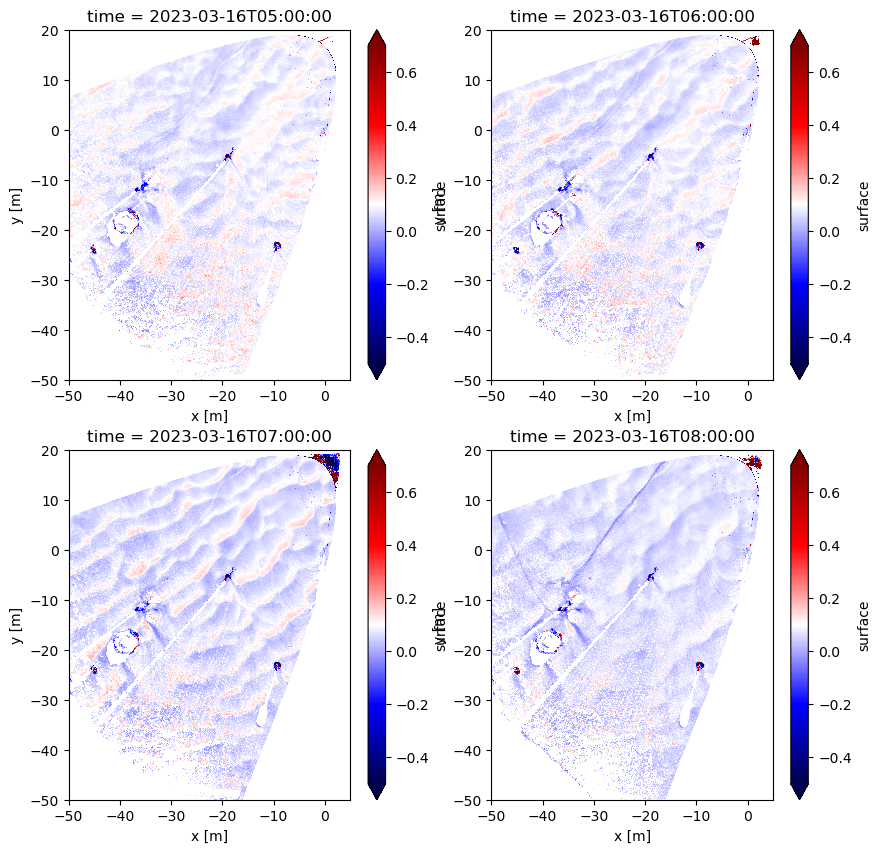

In [13]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
normed_1.plot(vmin=-0.5, vmax=0.7, cmap='seismic', ax=axes.flatten()[0])
normed_2.plot(vmin=-0.5, vmax=0.7, cmap='seismic', ax=axes.flatten()[1])
normed_3.plot(vmin=-0.5, vmax=0.7, cmap='seismic', ax=axes.flatten()[2])
normed_4.plot(vmin=-0.5, vmax=0.7, cmap='seismic', ax=axes.flatten()[3])

It's still kind of hard to tell... let's create a GIF from all timestamps in our dataset.

In [14]:
import imageio

In [15]:
# ChatGPT wrote the function below... pretty cool

# Define a function named create_gif_from_plots that takes two arguments: ds (lidar dataset) and output_gif (name of the output GIF file)
def create_gif_from_plots(ds, output_gif):
    # Create an empty list to store the filenames of the plot images
    filenames = []
    
    # Iterate over all time steps in the lidar dataset
    for i, time_step in enumerate(ds.time):
        # Normalize the data by subtracting the pixel-wise mean from the surface values at the current time step
        normed = ds.sel(time=time_step)['surface'] - np.nanmean(ds['surface'], axis=(0))
        # Create a new plot figure
        plt.figure()
        # Plot the normalized data using a colormap and set the color range
        normed.plot(vmin=-0.5, vmax=0.7, cmap='seismic')
        # Set the title of the plot to indicate the current time step
        plt.title(f'Time step: {i}')
        # Save the plot as an image file with a filename that includes the current time step index
        filename = f'plot_{i}.png'
        plt.savefig(filename)
        # Append the filename to the list of filenames
        filenames.append(filename)
        # Close the plot figure to free up memory
        plt.close()
    
    # Create a GIF from the saved image files
    with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
        # Iterate over the filenames of the plot images
        for filename in filenames:
            # Read the image file
            image = imageio.imread(filename)
            # Append the image to the GIF writer
            writer.append_data(image)
    # Optionally, remove the image files after creating the GIF
    for filename in filenames:
        os.remove(filename)

# Example usage
# Call the create_gif_from_plots function with the lidar dataset 'ds' as the argument
create_gif_from_plots(ds, 'lidar_timeseries.gif')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_55907/60621161.py:11: RuntimeWarning: Mean of empty slice
  normed = ds.sel(time=time_step)['surface'] - np.nanmean(ds['surface'], axis=(0))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_55907/60621161.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [16]:
from IPython.display import Image

Image(url='output.gif')

Check out the gif - do you see the dune migration? Cool!

What are the wind speeds during this day? What did the blowing snow fluxes look like?

In [17]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

VARIABLES = [
    'spd_1m_ue',
    'spd_3m_ue',
    'spd_10m_ue',
    'SF_avg_1m_ue',
    'SF_avg_2m_ue'
]

In [18]:
ds.time[19].values

numpy.datetime64('2023-03-16T05:00:00.000000000')

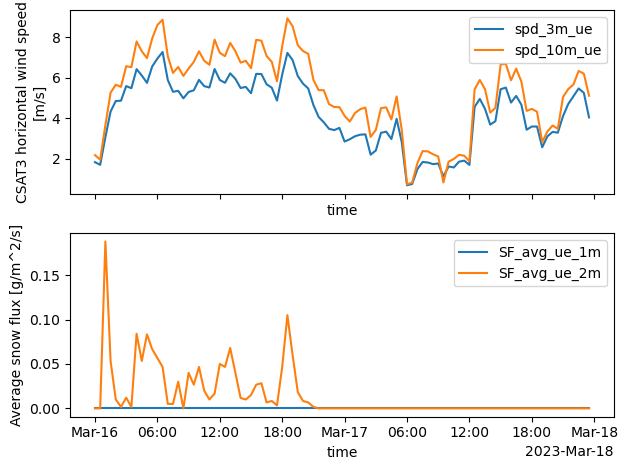

In [19]:
fig, axes = plt.subplots(2,1, sharex=True)

sos_dataset.sel(time = slice('2023-03-16', '2023-03-17'))['spd_3m_ue'].plot(label='spd_3m_ue', ax=axes[0])
sos_dataset.sel(time = slice('2023-03-16', '2023-03-17'))['spd_10m_ue'].plot(label='spd_10m_ue', ax=axes[0])

sos_dataset.sel(time = slice('2023-03-16', '2023-03-17'))['SF_avg_1m_ue'].plot(label='SF_avg_ue_1m', ax=axes[1])
sos_dataset.sel(time = slice('2023-03-16', '2023-03-17'))['SF_avg_2m_ue'].plot(label='SF_avg_ue_2m', ax=axes[1])

axes[0].legend()
axes[1].legend()
plt.tight_layout()

Same as above but using altair

In [20]:
sos_df = sos_dataset[[ 
    'spd_3m_ue', 'spd_10m_ue', 'SF_avg_1m_ue', 'SF_avg_2m_ue'
]].to_dataframe().loc['2023-03-16': '2023-03-17'].reset_index()
base = alt.Chart(sos_df).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N')
).properties(width=500, height=200)

base.transform_fold(['spd_3m_ue', 'spd_10m_ue']) &\
base.transform_fold(['SF_avg_1m_ue', 'SF_avg_2m_ue'])


alt.VConcatChart(...)

These wind speeds are consistent with known wind speeds for snow dune formation (5-8 m/s)